## NoteBook One - Data Cleaning

### Basic Import

In [0]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (94.8 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 132684 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
import pathlib
from skimage.color import rgb2gray
from google.colab import drive

### Fetch raw data

In [0]:
# Mount drive
drive.mount('/gdrive',force_remount=True)
drive_root = '/gdrive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
data_root = pathlib.Path('/gdrive/My Drive/Applied_Deep_Learning/slide_full')
all_mask_paths = sorted(list(data_root.glob('*mask.tif')))
all_image_paths = sorted(list(filter(lambda x: x not in all_mask_paths, list(data_root.glob('*.tif')))))
all_mask_names = list(map(lambda x: x.name.split('_')[1], all_mask_paths))
all_image_names = list(map(lambda x: x.name.split('_')[1].split('.')[0], all_image_paths))

In [0]:
# make sure all images have corresponding masks
# we find out that image 38 doesn't have correspond mask, so we manully delete it on drive
assert set(all_mask_names) - set(all_image_names) == set()
assert set(all_image_names) - set(all_mask_names) == set()

In [0]:
# Verify downsampling works as expected
for path in all_image_paths:
  slide = open_slide(str(path))
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

for path in all_mask_paths:
  slide = open_slide(str(path))
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

### Visualize the dataset

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    """
    function: read_slide => array with shape (height, width, 3)
    inputs: (x, y) => the coordinate of the top-left point
            level => zoom level
            width => output width
            height => output hight
            as_float => whether return array with float
    """


    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


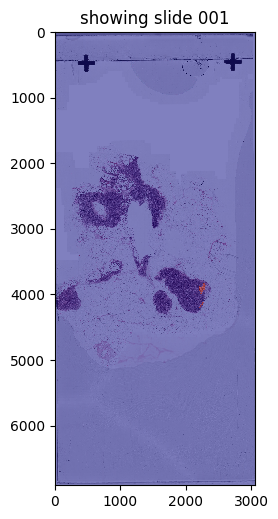

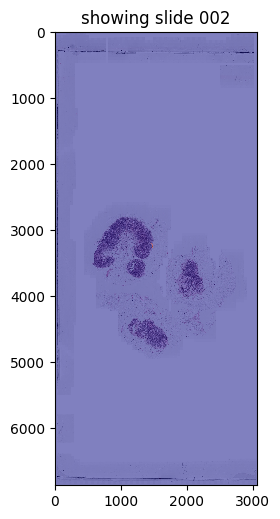

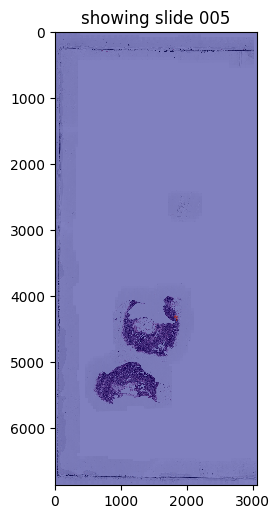

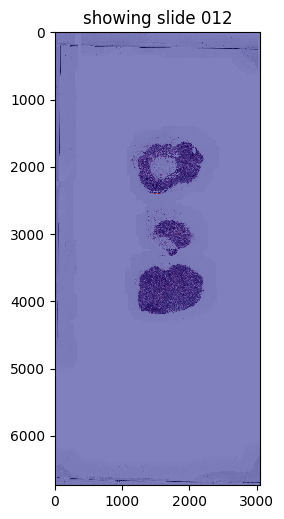

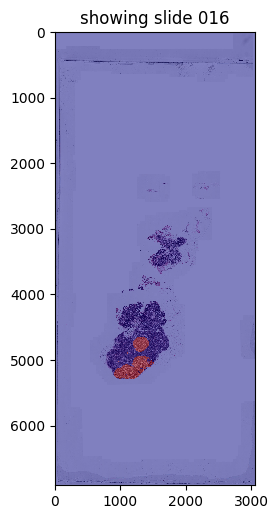

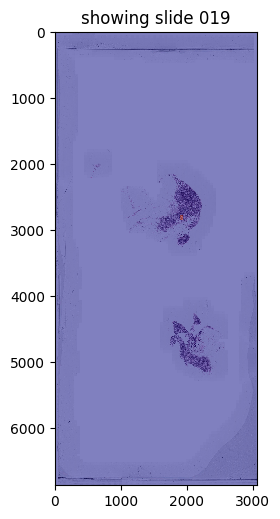

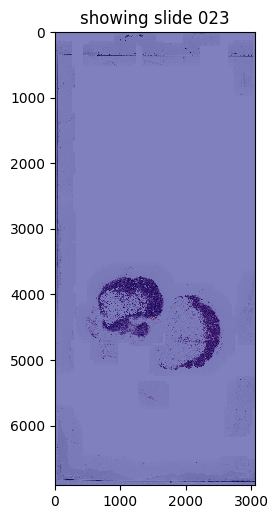

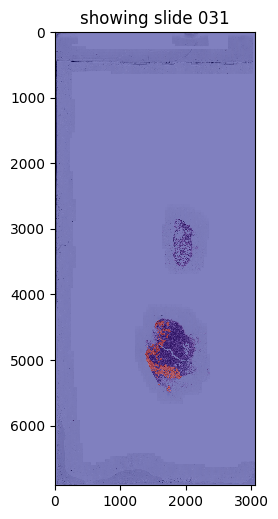

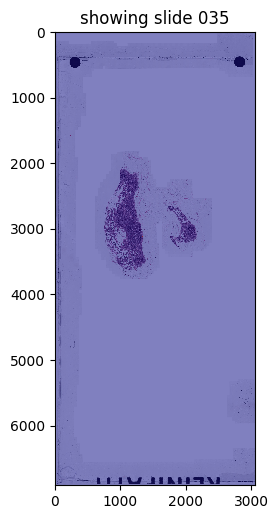

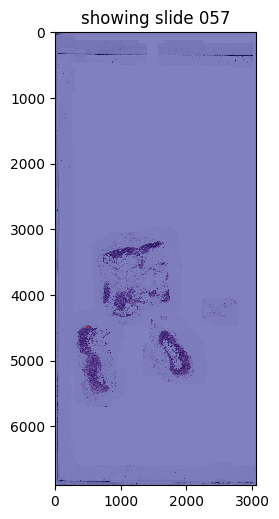

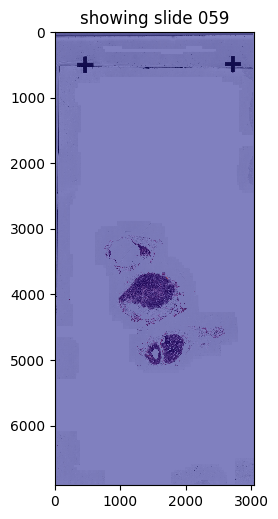

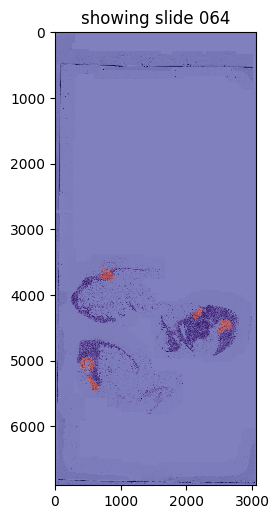

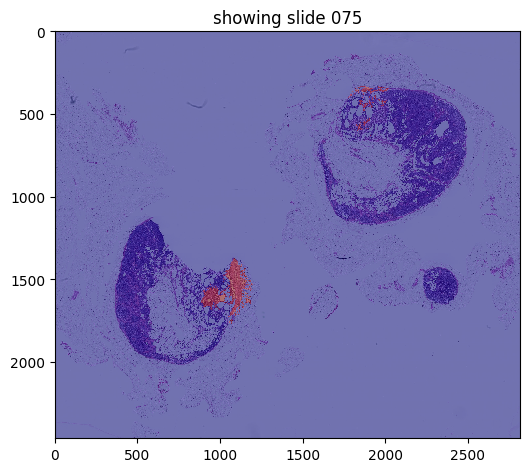

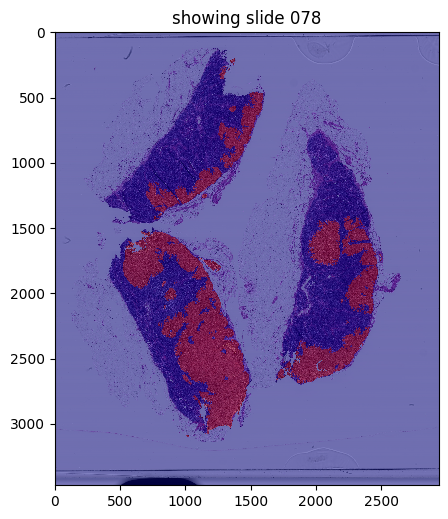

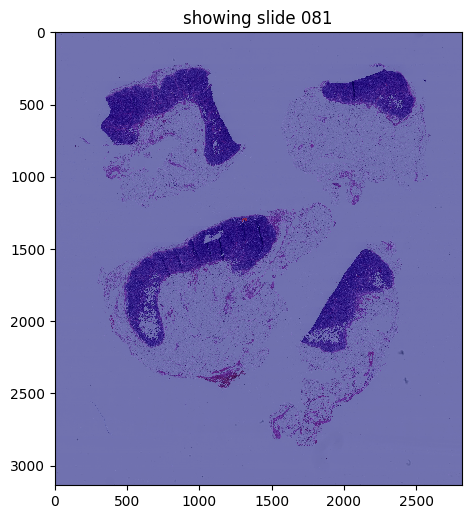

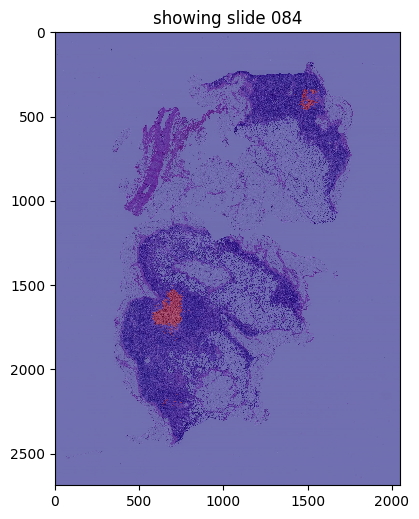

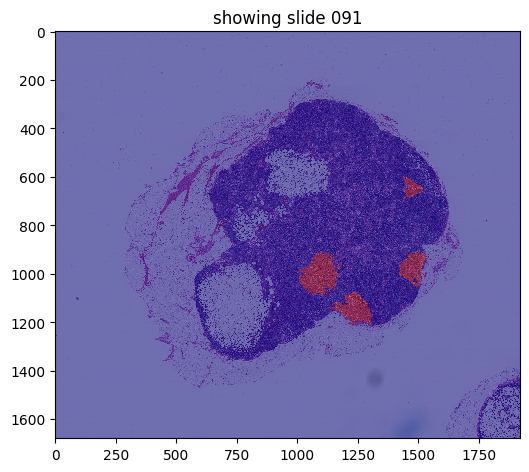

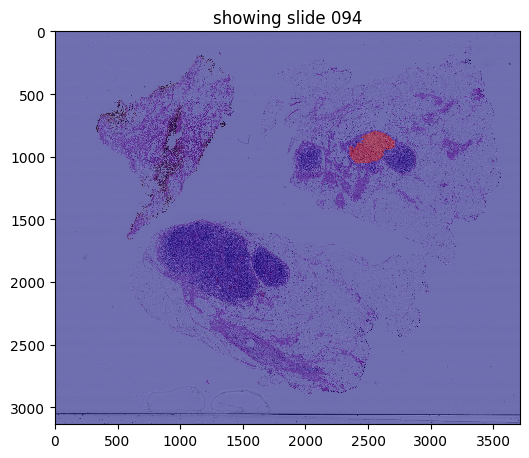

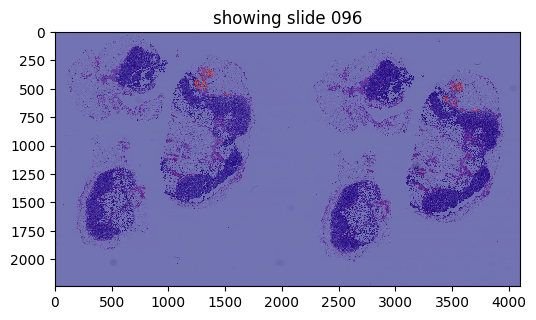

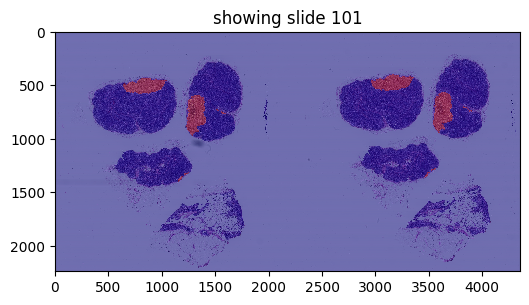

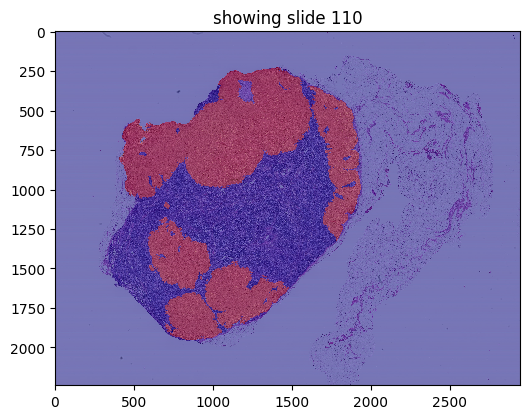

In [0]:
for image_path, mask_path in zip(all_image_paths, all_mask_paths):
  image_slide = open_slide(str(image_path))
  image = read_slide(image_slide, 
                     x=0, 
                     y=0, 
                     level=5, 
                     width=image_slide.level_dimensions[5][0], 
                     height=image_slide.level_dimensions[5][1])

  mask_slide = open_slide(str(mask_path))
  mask = read_slide(mask_slide, 
                    x=0, 
                    y=0, 
                    level=5, 
                    width=mask_slide.level_dimensions[5][0], 
                    height=mask_slide.level_dimensions[5][1])[:,:,0]
  
  plt.figure(figsize=(6, 6), dpi=100)
  plt.title(f"showing slide {image_path.name.split('_')[1].split('.')[0]}")
  plt.imshow(image)
  plt.imshow(mask, cmap='jet', alpha=0.5) # Red regions contains cancer.

### Create Validation / Testset

There are 21 images totally, so I will randomly select two images as validation and 3 as testset

Validation Set

In [0]:
random.choice(all_image_paths)

PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_002.tif')

In [0]:
random.choice(all_image_paths)

PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_057.tif')

Test Set

In [0]:
random.choice(all_image_paths)

PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_096.tif')

In [0]:
random.choice(all_image_paths)

PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_075.tif')

In [0]:
random.choice(all_image_paths)

PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_091.tif')

So we will retain slides 02 and 57 as validationset, 096, 075, 091 as testset

In [0]:
trainset_image_path = list(filter(lambda x: '002' not in str(x) and '057' not in str(x) and '096' not in str(x) and '075' not in str(x) and '091' not in str(x), 
                                  all_image_paths))
trainset_mask_path = list(filter(lambda x: '002' not in str(x) and '057' not in str(x) and '096' not in str(x) and '075' not in str(x) and '091' not in str(x), 
                                 all_mask_paths))

val_image_path = list(filter(lambda x: '002' in str(x) or '057' in str(x), 
                             all_image_paths))
val_mask_path = list(filter(lambda x: '002' in str(x) or '057' in str(x), 
                            all_mask_paths))

testset_image_path = list(filter(lambda x: '096' in str(x) or '075' in str(x) or '091' in str(x), 
                             all_image_paths))
testset_mask_path = list(filter(lambda x: '096' in str(x) or '075' in str(x) or '091' in str(x), 
                            all_mask_paths))

In [0]:
trainset_image_path # double check

[PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_001.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_005.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_012.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_016.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_019.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_023.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_031.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_035.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_059.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_064.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_078.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_081.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/s

In [0]:
trainset_mask_path

[PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_001_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_005_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_012_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_016_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_019_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_023_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_031_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_035_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_059_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_064_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_078_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_081_mask

In [0]:
val_image_path

[PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_002.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_057.tif')]

In [0]:
val_mask_path

[PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_002_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_057_mask.tif')]

In [0]:
testset_image_path

[PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_075.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_091.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_096.tif')]

In [0]:
testset_mask_path

[PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_075_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_091_mask.tif'),
 PosixPath('/gdrive/My Drive/Applied_Deep_Learning/slide_full/tumor_096_mask.tif')]

### Slice the dataset to create patches

Find tissues and extract them to increase model accuracy

In [0]:
def find_tissue_pixels(image, intensity=0.8):
    """
    function: image => (indices 0, indices 1), the location of tissue pixels

    """
    
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity) # the darker the more likely to be tissue
    return zip(indices[0], indices[1])
  
def apply_mask(im, mask, color=(255,0,0)):
    """
    function: image => new image with only tissue
    inputs: im: images
            mask: the location of tissue pixels
            color: the color of the tissue pixels
    """


    masked = np.copy(im)
    for x,y in mask: 
      masked[x][y] = color
    return masked

def extract_tissue(slide_image):
  """
  function: slide_image => images with only tissue (in red color)
  color = (255,0,0) => red
  
  """
  return apply_mask(slide_image, find_tissue_pixels(slide_image, intensity=0.8), color=(255,0,0))

Convert absolute path to slides

In [0]:
def path_to_slide(path):
  return open_slide(str(path))

trainset_tumor_slide = list(map(lambda path: path_to_slide(path), trainset_image_path))
trainset_mask_slide = list(map(lambda path: path_to_slide(path), trainset_mask_path))
trainset_name = list(map(lambda x: x.name, trainset_image_path))

val_tumor_slide = list(map(lambda path: path_to_slide(path), val_image_path))
val_mask_slide = list(map(lambda path: path_to_slide(path), val_mask_path))
val_name = list(map(lambda x: x.name, val_image_path))

testset_tumor_slide = list(map(lambda path: path_to_slide(path), testset_image_path))
testset_mask_slide = list(map(lambda path: path_to_slide(path), testset_mask_path))

Create Labels: Check whether tumors exist at the center

In [0]:
def center_tumor_check(mask, center_size = 128, patch_size = 299):
  """
  function: mask => boolean, whether tumor exist at the center of each patch
  
  """


  gap = (patch_size - center_size) // 2
  return np.sum(mask[gap : gap + center_size, gap : gap + center_size]) > 0 

Sampling function: Get the patch centerd at (x, y)

In [0]:
def get_patch(slide, tumor_mask, x, y, zoom_level, patch_size = 299):
  """
  function: slide, tumor => slide_image, mask_image
            get the patch centered at coordinate (x, y)
  """

  x = int(x) # in case cropping with return float
  y = int(y)
  gap = int(patch_size //2 * slide.level_downsamples[zoom_level])
    
  slide_image = read_slide(slide, 
                           x - gap, 
                           y - gap, 
                           zoom_level, 
                           width=patch_size, 
                           height=patch_size)
  mask_image = read_slide(tumor_mask, 
                          x - gap, 
                          y - gap, 
                          zoom_level, 
                          width=patch_size, 
                          height=patch_size)[:, :, 0]
  return slide_image, mask_image

Check whether tumor exist in a slide to make sure we sample slide with normal & tumor with equal probability

In [0]:
def check_pixels(mask_slide, level = 5, patch_size = 299):
  """
  function: mask_slide => boolean, whether tumor inside the sldie
  
  """


  mask = read_slide(mask_slide, 
                    0, 
                    0, 
                    level, 
                    width=mask_slide.level_dimensions[level][0], 
                    height=mask_slide.level_dimensions[level][1])[:,:,0]
  return np.sum(mask[:,:]) != np.sum(np.ones_like(mask[:,:])), np.sum(mask[:,:]) > 0

Speed up sampling process: Check normal pixels and tumor pixels location

In [0]:
def tumor_normal_pixels(tumor_slide, mask_slide, base_zoom_level = 5, patch_size = 299):
  """
  function: tumor_slide, mask_slide => (normal_pixels, tumor_pixels)
  
  """
  
  slide_image = read_slide(tumor_slide,
                           x=0,
                           y=0,
                           level=base_zoom_level,
                           width=tumor_slide.level_dimensions[base_zoom_level][0],
                           height=tumor_slide.level_dimensions[base_zoom_level][1])
  mask_image = read_slide(mask_slide,
                          x=0,
                          y=0,
                          level=base_zoom_level,
                          width=mask_slide.level_dimensions[base_zoom_level][0],
                          height=mask_slide.level_dimensions[base_zoom_level][1])[:,:,0]
  
  cropped_image = slide_image[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
  cropped_mask  = mask_image[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]

  cropped_image = extract_tissue(cropped_image)

  tissue_without_tummor = cropped_image[:, :, 0] - 255 * cropped_mask
  normal_pixels = list(zip(*np.where(tissue_without_tummor != 0)))
  tumor_pixels = list(zip(*np.where(cropped_mask != 0)))

  normal_pixels = list(map(lambda x: (x[1] + patch_size//2, x[0]+ patch_size//2), normal_pixels))
  tumor_pixels = list(map(lambda x: (x[1] + patch_size//2 ,x[0] + patch_size//2), tumor_pixels))

  return normal_pixels, tumor_pixels 


Generate images

In [0]:
def generate_slide(trainset_name, tumor_slides, mask_slides, zoom_level_1, zoom_level_2, 
                   random_seed = None,
                   base_zoom_level = 5, num_samples = 3000, patch_size= 299, 
                   center_size = 128, select_from_pixels = False, set_tissue_percentage = 0.3):
  """
  function: tumor_slide, mask_slide => zoom_level 1 images, zoom_level 2 images, labels
  inputs: 
        trainset_name: list of slide name
        tumor_slides: list of tumor slides,
        mask_slides: list of mask slides,
        zoom_level_1, zoom_level_2, the two zoom level of sample patches,
        random_seed: control randomness,
        base_zoom_level: the checking zoom level for human readable,
        num_samples: number of sample patches output,
        patch_size: the size of each patch,
        center_size: the size of the center area
        select_from_pixels: whether select from pre-calculated pixels or randonly select
        set_tissue_pertange: minimal tissue percentage contained in a patch

  """
  if random_seed:
    random.seed(random_seed)
    np.random.seed(random_seed)

  num_normal = num_samples/2
  num_tumor = num_samples/2

  slides_normal = [] # contains (images,mask) pairs
  slides_tumor = []  # contains (images,mask) pairs


  # define how many patches we should sample for each slide
  for tumor_slide, mask_slide in zip(tumor_slides,mask_slides):
    if check_pixels(mask_slide)[0]:
      slides_normal.append((tumor_slide, mask_slide))
    if check_pixels(mask_slide)[1]:
      slides_tumor.append((tumor_slide, mask_slide))
  
  print(f"There {len(slides_normal)} slides that have normal pixels")
  print(f"There {len(slides_tumor)} slides that have tumor pixels",'\n')

  num_normal_patch_on_each_slide = np.random.multinomial(num_normal, (1/len(slides_normal)) * np.array([1 for i in slides_normal]))
  num_tumor_patch_on_each_slide = np.random.multinomial(num_tumor, (1/len(slides_tumor)) * np.array([1 for i in slides_tumor]))

  print(f"Sampling {num_normal_patch_on_each_slide} number of patches on slides with normal pixels")
  print(f"Sampling {num_tumor_patch_on_each_slide} number of patches on slides with tumor pixels",'\n')

  assert num_normal_patch_on_each_slide.sum() == num_normal
  assert num_normal_patch_on_each_slide.sum() == num_tumor


  zoom_level1_result = []
  zoom_level2_result = []
  label = []

  # sampling the patches from each slide
  for name, tumor_slide, mask_slide, num_from_tumor, num_from_normal in zip(trainset_name,
                                                                            tumor_slides, 
                                                                            mask_slides,
                                                                            num_tumor_patch_on_each_slide,
                                                                            num_normal_patch_on_each_slide):
    slide_image = read_slide(tumor_slide, 
                             0, 
                             0, 
                             base_zoom_level, 
                             width=mask_slide.level_dimensions[base_zoom_level][0], 
                             height=mask_slide.level_dimensions[base_zoom_level][1])
    mask_image = read_slide(mask_slide, 
                            0, 
                            0, 
                            base_zoom_level, 
                            width=mask_slide.level_dimensions[base_zoom_level][0], 
                            height=mask_slide.level_dimensions[base_zoom_level][1])[:,:,0]

    assert slide_image.shape[0:2] == mask_image.shape


    count_tumor = 0
    count_normal = 0

    if select_from_pixels:
        normal_pixels, tumor_pixels = tumor_normal_pixels(tumor_slide, mask_slide, 
                                                          base_zoom_level, 
                                                          patch_size)

    while count_tumor <  num_from_tumor or count_normal < num_from_normal:
      if select_from_pixels:
        if count_tumor <  num_from_tumor:
          x, y = random.choice(tumor_pixels)
        else:
          x, y = random.choice(normal_pixels)
      else:
        x = np.random.randint(patch_size//2, int(slide_image.shape[1] - patch_size//2))
        y = np.random.randint(patch_size//2, int(slide_image.shape[0] - patch_size//2))
      
      x = x * tumor_slide.level_downsamples[base_zoom_level] # map it back to original coordinates
      y = y * mask_slide.level_downsamples[base_zoom_level]

      patch_image_l1, patch_mask_l1 = get_patch(tumor_slide, mask_slide, x, y, zoom_level_1, patch_size)
      patch_image_l2, patch_mask_l2 = get_patch(tumor_slide, mask_slide, x, y, zoom_level_2, patch_size)


      tissue_pixels = find_tissue_pixels(patch_image_l2)
      tissue_percentage = len(list(tissue_pixels)) / patch_size**2 * 100

      if center_tumor_check(patch_mask_l1, center_size, patch_size):
        if count_tumor < num_from_tumor and tissue_percentage >= set_tissue_percentage:
          zoom_level1_result.append(patch_image_l1)
          zoom_level2_result.append(patch_image_l2)
          label.append(1)
          count_tumor = count_tumor + 1
      else:
        if count_normal < num_from_normal and tissue_percentage >= set_tissue_percentage:
          zoom_level1_result.append(patch_image_l1)
          zoom_level2_result.append(patch_image_l2)
          label.append(0)
          count_normal = count_normal + 1
  
    assert count_tumor == num_from_tumor
    assert count_normal == num_from_normal
  
    print(f"Finished sampling {str(count_tumor)} tumor patches and {str(count_normal)} normal patches from slide {name} ")

  assert len(zoom_level1_result) == num_samples 
  assert len(zoom_level2_result) == num_samples 
  assert len(label) == num_samples

  return zoom_level1_result, zoom_level2_result, label


In [0]:
train_zoom_level1_result, train_zoom_level2_result, train_label = generate_slide(trainset_name, 
                                                                                 trainset_tumor_slide, 
                                                               trainset_mask_slide, zoom_level_1 = 0, 
                                                               zoom_level_2 = 1, 
                                                               random_seed = None,
                                                               base_zoom_level = 5, num_samples = 4000, 
                                                               patch_size= 299, 
                                                               center_size = 128, select_from_pixels = True, 
                                                               set_tissue_percentage = 0.3)

val_zoom_level1_result, val_zoom_level2_result, val_label = generate_slide(val_name, val_tumor_slide, 
                                                               val_mask_slide, zoom_level_1 = 0, 
                                                               zoom_level_2 = 1, 
                                                               random_seed = None,
                                                               base_zoom_level = 5, num_samples = 800, 
                                                               patch_size= 299, 
                                                               center_size = 128, select_from_pixels = True, 
                                                               set_tissue_percentage = 0.3)


There 16 slides that have normal pixels
There 16 slides that have tumor pixels 

Sampling [126 133 124 128 116 116 120 122 108 125 133 133 132 123 130 131] number of patches on slides with normal pixels
Sampling [123 122 131 135 134 121 138 130 114 131 130 115 127 125 118 106] number of patches on slides with tumor pixels 

Finished sampling 123 tumor patches and 126 normal patches from slide tumor_001.tif 
Finished sampling 122 tumor patches and 133 normal patches from slide tumor_005.tif 
Finished sampling 131 tumor patches and 124 normal patches from slide tumor_012.tif 
Finished sampling 135 tumor patches and 128 normal patches from slide tumor_016.tif 
Finished sampling 134 tumor patches and 116 normal patches from slide tumor_019.tif 
Finished sampling 121 tumor patches and 116 normal patches from slide tumor_023.tif 
Finished sampling 138 tumor patches and 120 normal patches from slide tumor_031.tif 
Finished sampling 130 tumor patches and 122 normal patches from slide tumor_035

Define the function to save patches as np arrays

In [0]:
def saving_results(saving_path, zoom_level1_result, zoom_level2_result, 
                   label, is_train = True):
  assert len(zoom_level1_result) == len(zoom_level2_result)
  assert len(zoom_level1_result) == len(label)

  zoom1 = np.array(zoom_level1_result)
  zoom2 = np.array(zoom_level2_result)
  label_final = np.array(label)

  if not os.path.exists(os.path.join(saving_path, 'train')):
    os.mkdir(os.path.join(saving_path, 'train'))
  if not os.path.exists(os.path.join(saving_path, 'val')):
    os.mkdir(os.path.join(saving_path, 'val'))

  if is_train:
    np.save(os.path.join(saving_path, 'train') + '/zoom1.npy', zoom1)
    np.save(os.path.join(saving_path, 'train') + '/zoom2.npy', zoom2)
    np.save(os.path.join(saving_path, 'train') + '/label.npy', label_final)
  else:
    np.save(os.path.join(saving_path, 'val') + '/zoom1.npy', zoom1)
    np.save(os.path.join(saving_path, 'val') + '/zoom2.npy', zoom2)  
    np.save(os.path.join(saving_path, 'val') + '/label.npy', label_final)

In [0]:
saving_path = '/gdrive/My Drive/Applied_Deep_Learning/project'

saving_results(saving_path, train_zoom_level1_result, train_zoom_level2_result, 
               train_label, is_train = True)

saving_results(saving_path, val_zoom_level1_result, val_zoom_level2_result, 
               val_label, is_train = False)

Sanity Check

In [0]:
saving_path = '/gdrive/My Drive/Applied_Deep_Learning/project'

train_zoom1 = np.load(os.path.join(saving_path, 'train') + '/zoom1.npy')
train_zoom2 = np.load(os.path.join(saving_path, 'train') + '/zoom2.npy')
train_label = np.load(os.path.join(saving_path, 'train') + '/label.npy')

val_zoom1 = np.load(os.path.join(saving_path, 'val') + '/zoom1.npy')
val_zoom2 = np.load(os.path.join(saving_path, 'val') + '/zoom2.npy')
val_label = np.load(os.path.join(saving_path, 'val') + '/label.npy')

Normal


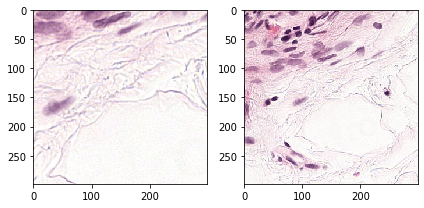

In [0]:
%matplotlib inline
idx = random.randint(0,len(train_zoom1)-1)
plt.subplot(1, 2, 1)
plt.imshow(train_zoom1[idx])
plt.subplot(1, 2, 2)
plt.imshow(train_zoom2[idx])
plt.tight_layout() 
if train_label[idx] == 0:
  print('Normal')
else:
  print('Tumor')

Normal


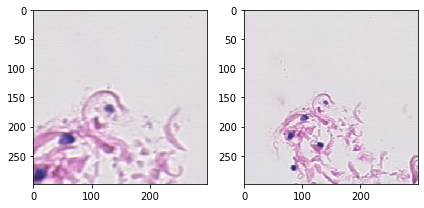

In [0]:
%matplotlib inline
idx = random.randint(0,len(train_zoom1)-1)
plt.subplot(1, 2, 1)
plt.imshow(train_zoom1[idx])
plt.subplot(1, 2, 2)
plt.imshow(train_zoom2[idx])
plt.tight_layout() 
if train_label[idx] == 0:
  print('Normal')
else:
  print('Tumor')

Tumor


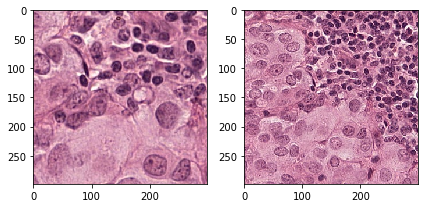

In [0]:
%matplotlib inline
idx = random.randint(0,len(train_zoom1)-1)
plt.subplot(1, 2, 1)
plt.imshow(train_zoom1[idx])
plt.subplot(1, 2, 2)
plt.imshow(train_zoom2[idx])
plt.tight_layout() 
if train_label[idx] == 0:
  print('Normal')
else:
  print('Tumor')

Tumor


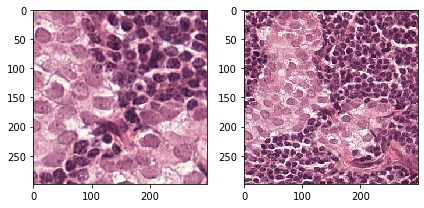

In [0]:
%matplotlib inline
idx = random.randint(0,len(val_zoom1)-1)
plt.subplot(1, 2, 1)
plt.imshow(val_zoom1[idx])
plt.subplot(1, 2, 2)
plt.imshow(val_zoom2[idx])
plt.tight_layout() 
if val_label[idx] == 0:
  print('Normal')
else:
  print('Tumor')

Tumor


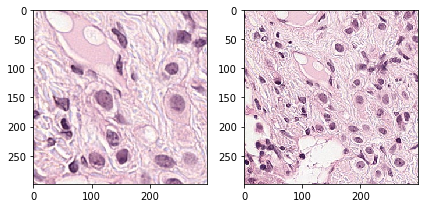

In [0]:
%matplotlib inline
idx = random.randint(0,len(val_zoom1)-1)
plt.subplot(1, 2, 1)
plt.imshow(val_zoom1[idx])
plt.subplot(1, 2, 2)
plt.imshow(val_zoom2[idx])
plt.tight_layout() 
if val_label[idx] == 0:
  print('Normal')
else:
  print('Tumor')

Tumor


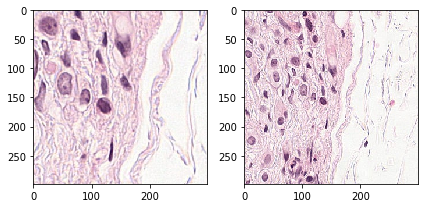

In [0]:
%matplotlib inline
idx = random.randint(0,len(val_zoom1)-1)
plt.subplot(1, 2, 1)
plt.imshow(val_zoom1[idx])
plt.subplot(1, 2, 2)
plt.imshow(val_zoom2[idx])
plt.tight_layout() 
if val_label[idx] == 0:
  print('Normal')
else:
  print('Tumor')

In [0]:
assert train_zoom1.shape == train_zoom2.shape
assert len(train_zoom1) == len(train_label)

assert val_zoom1.shape == val_zoom2.shape
assert len(val_zoom1) == len(val_label)

In [0]:
train_zoom1.shape

(4000, 299, 299, 3)

In [0]:
val_zoom1.shape

(800, 299, 299, 3)

NB1 Finished